# Notebook 1: Import and Preprocessing Pipeline and Initial Fit #

The aim of this project is to train a neural net to detect falling snow in images.

The data for this project is from [here](https://sites.google.com/view/yunfuliu/desnownet).  The training data provided on this website contains 50,000 images without falling snow, and a copy of each image with falling snow artifically added using a mask.  The images are all RBG-encoded .jpg files.  The size and aspect ratio of the images is variable, but no picture in the dataset has a width or height greater than 640 pixels.

Tensorflow will be used to build a pipeline that allows for shuffling, preprocessing, batching, and training of the images in such a way that this large dataset can be processed on a personal computer with a GPU and CUDA.  Neural nets will be trained using the binary cross-entropy metric, and then evaluated based on their performance according to multiple classification metrics, specifically precision, recall, f1 score, and accuracy.

Please see the README.md for a more in-depth discussion of the motivation for this project.

In this notebook, the following steps are completed:
- Set up a pipeline to import and preprocess the image data and perform an initial fit to ensure that everything is working.
- Save the model, its training history, and its predictions.
- Import a single image and use the trained model to predict whether there is snow in that image, a necessary process for later deployment.

In [1]:
# Common data science imports used in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic Python libraries used in this notebook
import time
import datetime
import os
import json

# A custom script I wrote to easily calculate and display classification metrics
import metrictools_snow as mts

# Tensorflow libraries for importing and preprocessing images
from tensorflow import io
from tensorflow import strings
from tensorflow import argmax
from tensorflow.data import AUTOTUNE
from tensorflow.data import Dataset
from tensorflow.image import resize_with_pad

# Building neural nets and loading saved models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

### Section I: Importing and Preprocessing Images as Tensorflow Datasets ###

This [tutorial](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control) was very useful for accomplishing this in a way that allowed me to handle a very large amount of data on a personal computer.

In [2]:
def get_image(file_path):
    
    # Given a Tensorflow filepath object, sets label to 0 if the second to last part of the path is 'clear' and 1 if it is 'snow'.
    parts = strings.split(file_path, os.path.sep)
    label = parts[-2] == ['clear', 'snow']
    
    # Reads in the image at the given filepath, which should be a jpeg.
    img = io.read_file(file_path)
    img = io.decode_jpeg(img)
    
    # Add buffer as necessary to resize image to 640x640 without changing aspect ratio.
    # 640 is the largest dimesion of any image in the dataset.
    img = resize_with_pad(img, 640, 640)
    
    # Normalize images so each pixel is in the range -1 to 1
    return (img - 127.5) / 127.5, argmax(label)

In [3]:
def get_data(img_folder_list, shuffle_seed, train_size=0.8):
    
    # Gets paths to all the files in the given folders holding the training data.  No shuffling is done yet.
    file_groups = [Dataset.list_files(folder+'*', shuffle=False) for folder in img_folder_list]
    
    train_num_0 = int(len(file_groups[0])*train_size) # Number of files in folder 0 to be used in training set
    train_num_1 = int(len(file_groups[1])*train_size) # Number of files in folder 1 to be used in training set
    
    # Select the files paths for training and validation from each folder.
    train_paths = file_groups[0].take(train_num_0).concatenate(file_groups[1].take(train_num_1))
    val_paths = file_groups[0].skip(train_num_0).concatenate(file_groups[1].skip(train_num_1))
    
    # Filepaths are now shuffled.  This will be redone in each epoch to randomize the order of images during training.
    train_paths = train_paths.shuffle(buffer_size=len(train_paths), reshuffle_each_iteration=True, seed=shuffle_seed)
    val_paths = val_paths.shuffle(buffer_size=len(val_paths), reshuffle_each_iteration=True, seed=shuffle_seed)
    
    # Use the get_image function to import the images, which are resized and normalized as they are imported.
    train_images = train_paths.map(get_image, num_parallel_calls=AUTOTUNE)
    val_images = val_paths.map(get_image, num_parallel_calls=AUTOTUNE)
    
    return train_images, val_images

In [4]:
# Execute the above functions to create Tensorflow Dataset objects for training.
folders = ['../data/train_val/clear/', '../data/train_val/snow/']
train_data, val_data = get_data(folders, shuffle_seed=632, train_size=0.8)

### *Need Markdown and Comments* ###

In [5]:
def get_test_data(img_folder_list, shuffle_seed):
    
    file_groups = [Dataset.list_files(folder+'*', shuffle=False) for folder in img_folder_list]
    
    small_paths = file_groups[0].concatenate(file_groups[1])
    medium_paths = file_groups[2].concatenate(file_groups[3])
    large_paths = file_groups[4].concatenate(file_groups[5])
    
    small_paths = small_paths.shuffle(buffer_size=len(small_paths), reshuffle_each_iteration=False, seed=shuffle_seed)
    medium_paths = medium_paths.shuffle(buffer_size=len(medium_paths), reshuffle_each_iteration=False, seed=shuffle_seed)
    large_paths = large_paths.shuffle(buffer_size=len(large_paths), reshuffle_each_iteration=False, seed=shuffle_seed)
    
    small_images = small_paths.map(get_image, num_parallel_calls=AUTOTUNE)
    medium_images = medium_paths.map(get_image, num_parallel_calls=AUTOTUNE)
    large_images = large_paths.map(get_image, num_parallel_calls=AUTOTUNE)
    
    return small_images, medium_images, large_images

In [6]:
folders = ['../data/test/small/clear/', '../data/test/small/snow/',
         '../data/test/medium/clear/', '../data/test/medium/snow/',
         '../data/test/large/clear/', '../data/test/large/snow/']
test_small, test_medium, test_large = get_test_data(folders, shuffle_seed=294)

### Section II: Initial model: test1 ###

In [7]:
# Batch datasets and tell Tensorflow to fetch the next batch while each batch is being fit.
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_small = test_small.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_medium = test_medium.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_large = test_large.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

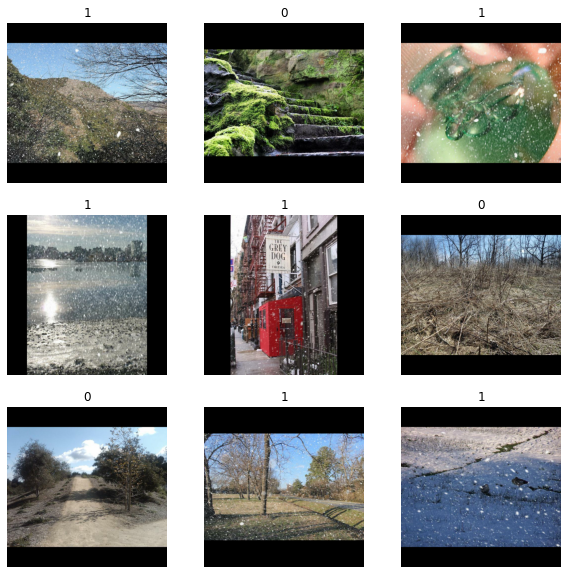

In [8]:
# Visualize a few of the pictures in the data set, along with their labels, to make sure it all looks good.
# First line gets the first batch of data.
image_batch, label_batch = next(iter(val_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # To display the image, the scaling of each pixel to the range [-1, 1] must be reversed.
    image = image_batch[i].numpy() * 127.5 + 127.5
    plt.imshow(image.astype("uint8"))
    # The label corresponding to each picture is taken as the title.
    label = label_batch[i]
    plt.title(label.numpy())
    plt.axis("off")

In [9]:
# This is a simple model used to ensure everything is working.
# The neural net is kept fairly small with basic hypterparameter and activation values.

model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5),
                        strides=(2, 2),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Conv2D(filters=8, kernel_size=(5,5),
                       strides=(2,2),
                       activation='leaky_relu',
                       padding='same'))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='leaky_relu'))

model.add(layers.Dense(8, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 305s 121ms/step - loss: 0.1574 - accuracy: 0.9314 - val_loss: 0.0760 - val_accuracy: 0.9743
Epoch 2/5
2500/2500 [==============================] - 316s 126ms/step - loss: 0.0712 - accuracy: 0.9753 - val_loss: 0.0755 - val_accuracy: 0.9722 - loss: 0.0712 - accuracy: 0.97
Epoch 3/5
2500/2500 [==============================] - 323s 129ms/step - loss: 0.0543 - accuracy: 0.9811 - val_loss: 0.0638 - val_accuracy: 0.9779
Epoch 4/5
2500/2500 [==============================] - 325s 130ms/step - loss: 0.0447 - accuracy: 0.9839 - val_loss: 0.0715 - val_accuracy: 0.9765
Epoch 5/5
2500/2500 [==============================] - 324s 129ms/step - loss: 0.0377 - accuracy: 0.9862 - val_loss: 0.0484 - val_accuracy: 0.9832


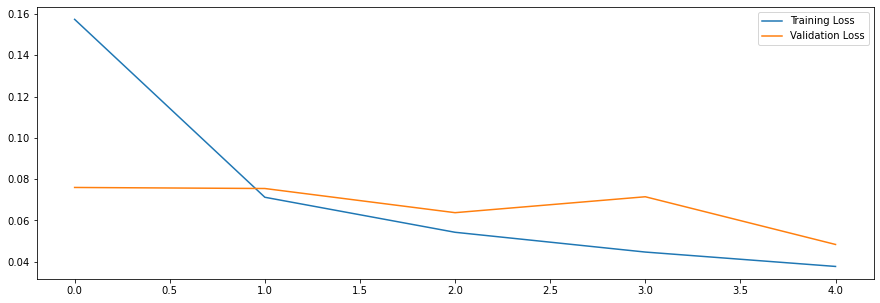

In [12]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

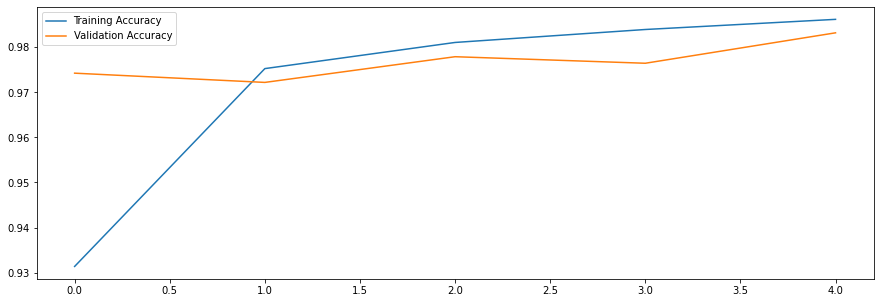

In [13]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

Considering this is a small CNN with simple hyperparameter choices, this is a very encouraging result. Validation accuracy closely matches training accuracy, so the model is not significantly overfitting despite the lack of any regularization in this model.  Validation loss and accuracy do begin to lag slightly behind training loss and accuracy, suggesting that the limits of this initial model are being reached.

### Section III: Save model, training history, predictions, and labels ###

In [14]:
model_name = 'test_model'

In [15]:
model.save(f'../saved_models/{model_name}/trained_model.pickle')

INFO:tensorflow:Assets written to: ../saved_models/test_model/trained_model.pickle\assets


This [link](https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history) showed me how to save the training history.

In [16]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}/training_hist.json', 'w'))

Generate predictions on the train and validation data and save them along with true values.  This allows more detailed future analysis of classification metrics.

In [17]:
def get_preds(data, model_name, which_data):
    labels = []
    preds = []
    for image_batch, label_batch in iter(val_data):
        labels.append(label_batch.numpy())
        preds.append(model.predict_on_batch(image_batch)[:,0])
    results = pd.DataFrame(zip(np.concatenate(labels), np.concatenate(preds)), columns=['true', 'pred'])
    results.to_csv(f'../saved_models/{model_name}/{which_data}_preds.csv', index=False)

In [18]:
get_preds(train_data, model_name, 'train')

In [19]:
get_preds(val_data, model_name, 'val')

In [20]:
get_preds(test_small, model_name, 'test_small')

In [21]:
get_preds(test_medium, model_name, 'test_medium')

In [22]:
get_preds(test_large, model_name, 'test_large')

### Section IV: Load the saved model and check its metrics. ###

In [23]:
load_model_name = 'test_model'

In [24]:
loaded_model = load_model(f'../saved_models/{load_model_name}/trained_model.pickle')

In [25]:
loaded_history_dict = json.load(open(f'../saved_models/{load_model_name}/training_hist.json', 'r'))

In [26]:
train_pred_df = pd.read_csv(f'../saved_models/{load_model_name}/train_preds.csv')
val_pred_df = pd.read_csv(f'../saved_models/{load_model_name}/val_preds.csv')
test_small_pred_df = pd.read_csv(f'../saved_models/{load_model_name}/test_small_preds.csv')
test_medium_pred_df = pd.read_csv(f'../saved_models/{load_model_name}/test_medium_preds.csv')
test_large_pred_df = pd.read_csv(f'../saved_models/{load_model_name}/test_large_preds.csv')

#### *Some kind of transition here* ####

In [27]:
# This function assigns a given number to either 0 or 1 according to a given cutoff.
def binarize_class(in_num, cutoff):
    if in_num < cutoff:
        return 0
    else:
        return 1

In [28]:
train_pred_df['pred_bin'] = train_pred_df['pred'].apply(binarize_class, args=(0.5,))

In [29]:
test_small_pred_df['pred_bin'] = test_small_pred_df['pred'].apply(binarize_class, args=(0.5,))

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9706    0.9772    0.9739     10000
        snow     0.9770    0.9704    0.9737     10000

    accuracy                         0.9738     20000
   macro avg     0.9738    0.9738    0.9738     20000
weighted avg     0.9738    0.9738    0.9738     20000

ROC AUC score: 0.9738000000000001

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9621    0.9768    0.9694     16611
        snow     0.9764    0.9615    0.9689     16611

    accuracy                         0.9691     33222
   macro avg     0.9693    0.9691    0.9691     33222
weighted avg     0.9693    0.9691    0.9691     33222

ROC AUC score: 0.9691469508157246

*************************



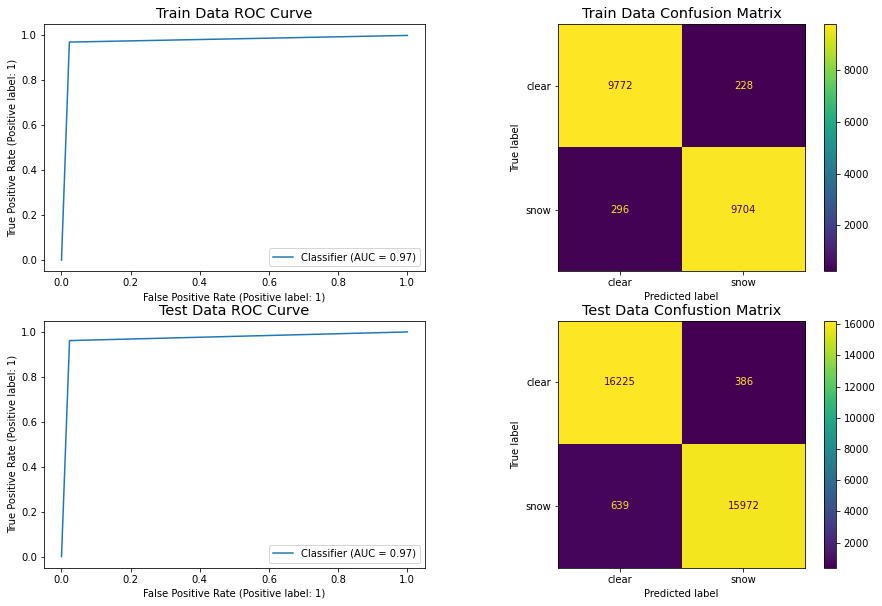

In [59]:
mts.check_metrics(train_pred_df['pred_bin'], test_small_pred_df['pred_bin'], train_pred_df['true'], test_small_pred_df['true'], 'clear', 'snow')

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9775    0.9932    0.9853     40052
        snow     0.9931    0.9771    0.9850     39948

    accuracy                         0.9851     80000
   macro avg     0.9853    0.9851    0.9851     80000
weighted avg     0.9853    0.9851    0.9851     80000

ROC AUC score: 0.9851395098857718

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9781    0.9932    0.9856     10054
        snow     0.9931    0.9775    0.9852      9946

    accuracy                         0.9854     20000
   macro avg     0.9856    0.9854    0.9854     20000
weighted avg     0.9855    0.9854    0.9854     20000

ROC AUC score: 0.9853574530233301

*************************



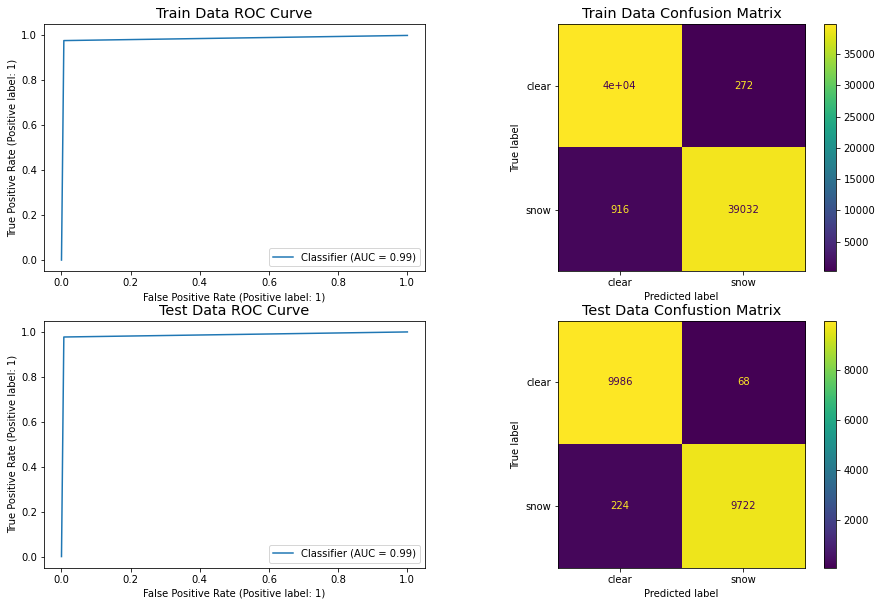

In [12]:
mts.check_metrics(train_pred_df['pred'], val_pred_df['pred'], train_pred_df['true'], val_pred_df['true'], 'clear', 'snow')

All metrics are nearly identical on the training and validaton data, indicating that the model is neither overfit nor underfit.  Precision is higher than recall when predicting an image has snow, suggesting that the model is more likely incorrectly predict a clear image than a snowy image.  The confusion matrices also show this fact, as we see more images incorrectly predicted to be clear than we see images incorrectly predicted to be snowy.

In the future, I will save the predictions to csv with their full decimal accuracy, rather than rounding.  This will allow me to easily check the impact of different certainty thresholds on the classification metrics.  Specifically, I can see if it is possible to shift precision and recall without negatively impacting overall accuracy or F1 score.  I think that for most applications, it will be more useful to have a higher recall when predicting snow, so snow is missed less often.

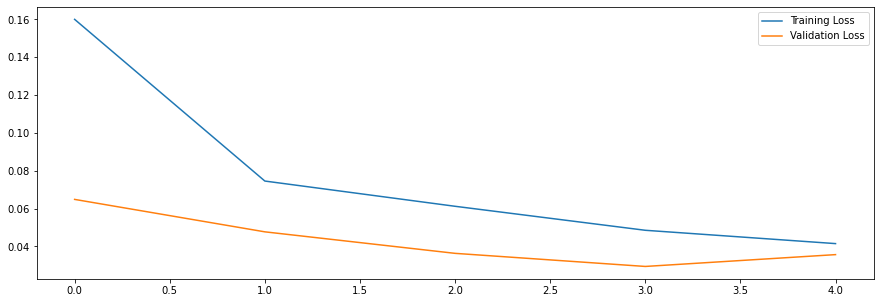

In [13]:
plt.figure(figsize=(15,5))
plt.plot(new_history_dict['loss'], label='Training Loss')
plt.plot(new_history_dict['val_loss'], label='Validation Loss')
plt.legend();

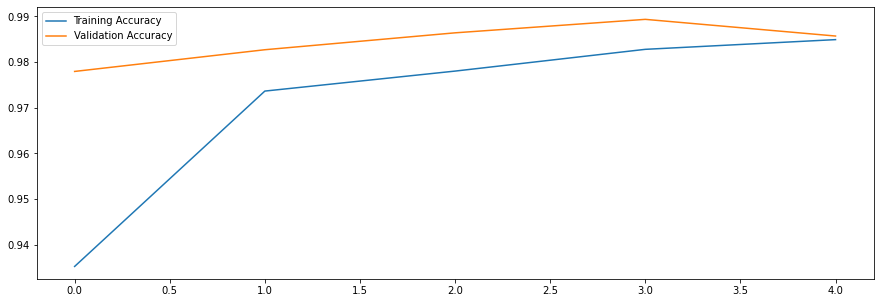

In [14]:
plt.figure(figsize=(15,5))
plt.plot(new_history_dict['accuracy'], label='Training Accuracy')
plt.plot(new_history_dict['val_accuracy'], label='Validation Accuracy')
plt.legend();

This is simply a replication of the training history graphs above using the saved and loaded model, confirming that the history was saved successfully.

### Section V: Predict the Class of Single Images ###

The saved model is used to predict the classes of single images that are not imported as part of a Tensorflow dataset.  This will be necessary for deployment.  Although my method differs somewhat, I used this [link](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) to help me alter a single input image so I could generate a prediction on it.

In [15]:
# Import the images and perform the same resizing and normalization that were performed on the training data.

test_snow_raw = io.read_file('../data/train/snow/beautiful_smile_00001.jpg')
test_clear_raw = io.read_file('../data/train/clear/beautiful_smile_00001.jpg')

test_snow_raw = io.decode_jpeg(test_snow_raw)
test_clear_raw = io.decode_jpeg(test_clear_raw)

test_snow_raw = resize_with_pad(test_snow_raw, 640, 640)
test_clear_raw = resize_with_pad(test_clear_raw, 640, 640)

test_snow = (test_snow_raw - 127.5) / 127.5
test_clear = (test_clear_raw - 127.5) / 127.5

# It is necessary to add a dummy axis where the original data had an axis representing the batch it was in.
test_snow = test_snow[np.newaxis, :]
test_clear = test_clear[np.newaxis, :]

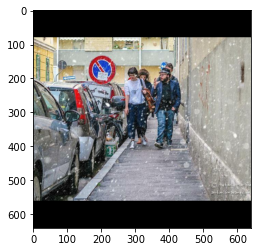

In [16]:
plt.imshow(test_snow_raw.numpy().astype("uint8"));

In [17]:
predict_snow = new_model.predict(test_snow)[0][0]
predict_snow

0.9999789

In [18]:
if round(predict_snow, 0) == 1:
    print('snow')
else:
    print('clear')

snow


The model successfully identifies this as a snowy image with very high certainty.

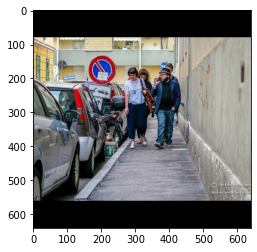

In [19]:
plt.imshow(test_clear_raw.numpy().astype("uint8"));

In [20]:
predict_clear = new_model.predict(test_clear)[0][0]
predict_clear

0.0051075662

In [21]:
if round(predict_clear, 0) == 1:
    print('snow')
else:
    print('clear')

clear


The model successfully identifies this as a clear image with high confidence.

This demonstrates the process that can be used to make predictions with this neural net on new images.

I have done the following in this notebook:
- Read in 100,000 images of different sizes and classified them with a simple CNN.
- Despite the fact that my purpose was to confirm the procedure worked and I did not tune hyperparameters very much, the CNN already demonstrates very high accuracy in classifying the images as snowy or clear.  This confirms that a convolutional neural network is capable of performing well on this problem.
- I generated predictions paired with true labels so classification metrics like f1 score, precision, and recall could be calculated.
- I saved the model, its training history, and the predictions and labels for future reference.
- I used the saved model to generate a prediction of snowy or clear on a single image that was not imported as a Tensorflow dataset, showing promise for future deployment.

Next steps include:
- Deploy this model in a streamlit app to make predictions on uploaded images.  In the future, I'm interested in extending this to work with videos and live webcams accessed via API.
- Further tune the model by hyperparameter gridsearching to maximize effectiveness.  Also experiment with pruning and quantization to reduce model size and increase speed.  Although there is likely room for improvement, the model already has excellent metrics, is less than 2 MB, and calculates predictions quickly.  This kind of tuning will be more important if future work demands a more complex or even faster model.